In [1]:
# import necessary package
from enum import Enum
import pandas as pd
import numpy as np

#print(pd.__version__)

OPEN = 0
HIGH = 1
LOW = 2

To do:

- [ ] 唐奇安通道突破法则：你应该在价格突破过去48小时内的最高点时买入，在价格跌破过去48小时内的最低点时卖空。
- [ ] 趋势组合过滤器：只能在120小时均线高于720小时均线的市场中做多，在120小时均线低于720小时均线的市场中做空。
- [ ] 同时满足以上两种情况。

In [2]:
# hourly trade data file
trade_file = "data/BTC-Hourly.csv"

df = pd.read_csv(trade_file)
df.sort_values("date", inplace=True)
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
33258,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93
33257,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58
33256,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79
33255,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62
33254,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69


In [3]:
class Status(Enum):
    
    BUY_IN = "BUY_IN"
    KEEP = "KEEP"
    SOLD_OUT = "SOLD_OUT"
    

    
#判断标志位
#策略1：唐奇安通道突破法则：在价格突破过去48小时内的最高点时买入，在价格跌破过去48小时内的最低点时卖出。
def strategy_1(cur_price, past_serials_48h):
    if cur_price > np.max(past_serials_48h[:,HIGH]):
        return Status.BUY_IN
    
    if cur_price < np.min(past_serials_48h[:,LOW]):
        return Status.SOLD_OUT
    
    return Status.KEEP

#策略2：趋势组合过滤器：在120小时均线高于720小时均线的市场中买入，在120小时均线低于720小时均线的市场中卖出。
def strategy_2(past_serials_short_120h, past_serials_long_720h):
    if np.average(past_serials_short_120h) > np.average(past_serials_long_720h):
        return Status.BUY_IN
    
    if np.average(past_serials_short_120h) < np.average(past_serials_long_720h):
        return Status.SOLD_OUT
    
    return Status.KEEP    
    
"""
#判断标志位
#策略1：唐奇安通道突破法则：在价格突破过去48小时内的最高点时买入，在价格跌破过去48小时内的最低点时卖出。
def strategy_1(cur_price, past_serials_48h):
    if cur_price > np.max(past_serials_48h[:,1]):
        return Status.BUY_IN
    
    if cur_price < np.min(past_serials_48h[:,2]):
        return Status.SOLD_OUT
    
    return Status.KEEP

#策略2：趋势组合过滤器：在120小时均线高于720小时均线的市场中买入，在120小时均线低于720小时均线的市场中卖出。
def strategy_2(past_serials_short_120h, past_serials_long_720h):
    if np.average(past_serials_short_120h) > np.average(past_serials_long_720h):
        return Status.BUY_IN
    
    if np.average(past_serials_short_120h) < np.average(past_serials_long_720h):
        return Status.SOLD_OUT
    
    return Status.KEEP
"""

'\n#判断标志位\n#策略1：唐奇安通道突破法则：在价格突破过去48小时内的最高点时买入，在价格跌破过去48小时内的最低点时卖出。\ndef strategy_1(cur_price, past_serials_48h):\n    if cur_price > np.max(past_serials_48h[:,1]):\n        return Status.BUY_IN\n    \n    if cur_price < np.min(past_serials_48h[:,2]):\n        return Status.SOLD_OUT\n    \n    return Status.KEEP\n\n#策略2：趋势组合过滤器：在120小时均线高于720小时均线的市场中买入，在120小时均线低于720小时均线的市场中卖出。\ndef strategy_2(past_serials_short_120h, past_serials_long_720h):\n    if np.average(past_serials_short_120h) > np.average(past_serials_long_720h):\n        return Status.BUY_IN\n    \n    if np.average(past_serials_short_120h) < np.average(past_serials_long_720h):\n        return Status.SOLD_OUT\n    \n    return Status.KEEP\n'

In [4]:
#三个维度的内容转化为numpy数组
trade_data_matrix = df[["open", "high", "low"]].to_numpy()
time_line = df["date"].to_list()

#print(time_line)

#48改为24
s1_time_span = 48
s2_short_time_span = 120
s2_long_time_span = 720
trade_ops = []


#同时符合策略1和2的情况

#print(trade_data_matrix)
#print(trade_data_matrix.shape)
#print(trade_data_matrix.shape[0])



for s1_time_span in range(2,720):
    
    max_profit = 0
    min_profit = 0
    
    # init conditions
    INIT_MONEY = 20000
    opening_money = 20000
    holding_btcs = 0

    
    cur_op = {
       "s1_time_span": s1_time_span,
    }
    
    #从第s1_time_span小时开始到最后
    for idx in range(s1_time_span, trade_data_matrix.shape[0]):
    #for idx in range(3060, 17000):
        #cur_op = {
        #    "trade_date": time_line[idx],
        #}
        #对应开盘价格
        cur_price = trade_data_matrix[idx,0]
        s1 = strategy_1(cur_price, trade_data_matrix[idx-s1_time_span:idx,:])
        #s2 = strategy_2(trade_data_matrix[idx-s2_short_time_span:idx,0], trade_data_matrix[idx-s2_long_time_span:idx,0])

        #cur_op["s1"] = str(s1)
        #cur_op["s2"] = str(s2)

        #cur_op["Max"] = np.max(trade_data_matrix[idx-s1_time_span:idx,:][:,1])

        if s1 == Status.BUY_IN:
            holding_btcs += opening_money / cur_price
            profit =  holding_btcs * cur_price - INIT_MONEY
            opening_money = 0
            holding_btcs = 0.999 * holding_btcs
            #cur_op["status"] = "buy"
        elif s1 == Status.SOLD_OUT:
            opening_money += holding_btcs * cur_price
            profit = opening_money - INIT_MONEY 
            holding_btcs = 0
            opening_money = 0.999 * opening_money
            #cur_op["status"] = "sold" 
        else:
            profit =  opening_money + holding_btcs * cur_price - INIT_MONEY
           #cur_op["status"] = "keep"
        
        if max_profit <= profit:
            max_profit = profit

        if min_profit >= profit:
            min_profit = profit
        #cur_op["profit"] = profit
        #cur_op["cur_price"] = cur_price
        #cur_op["btcs"] = holding_btcs
        #cur_op["cash"] = opening_money
        #cur_op["profit_rate"] = profit / INIT_MONEY * 100
    
    cur_op["max_profit"] = max_profit
    cur_op["min_profit"] = min_profit
    trade_ops.append(cur_op)

"""
for idx in range(73, 15000):
#for idx in range(3060, 17000):
    cur_op = {
        "trade_date": time_line[idx],
    }
    #对应开盘价格
    cur_price = trade_data_matrix[idx,0]
    s1 = strategy_1(cur_price, trade_data_matrix[idx-s1_time_span:idx,:])
    #s2 = strategy_2(trade_data_matrix[idx-s2_short_time_span:idx,0], trade_data_matrix[idx-s2_long_time_span:idx,0])
    
    cur_op["s1"] = str(s1)
    #cur_op["s2"] = str(s2)
    
    cur_op["Max"] = np.max(trade_data_matrix[idx-s1_time_span:idx,:][:,1])
    
    if s1 == Status.BUY_IN:
        holding_btcs += opening_money / cur_price
        profit =  holding_btcs * cur_price - INIT_MONEY
        opening_money = 0
        cur_op["status"] = "buy"
    elif s1 == Status.SOLD_OUT:
        opening_money += holding_btcs * cur_price
        profit = opening_money - INIT_MONEY 
        holding_btcs = 0
        cur_op["status"] = "sold" 
    else:
        profit =  opening_money + holding_btcs * cur_price - INIT_MONEY
        cur_op["status"] = "keep"
    
    cur_op["profit"] = profit
    cur_op["cur_price"] = cur_price
    cur_op["btcs"] = holding_btcs
    cur_op["cash"] = opening_money
    cur_op["profit_rate"] = profit / INIT_MONEY * 100

    trade_ops.append(cur_op)
"""
"""
#从第720小时开始到最后
for idx in range(720, trade_data_matrix.shape[0]):
    cur_op = {
        "trade_date": time_line[idx],
    }
    #对应开盘价格
    cur_price = trade_data_matrix[idx,0]
    s1 = strategy_1(cur_price, trade_data_matrix[idx-s1_time_span:idx,:])
    s2 = strategy_2(trade_data_matrix[idx-s2_short_time_span:idx,0], trade_data_matrix[idx-s2_long_time_span:idx,0])
    
    cur_op["s1"] = str(s1)
    cur_op["s2"] = str(s2)
    
    if s1 == Status.BUY_IN and s2 == Status.BUY_IN:
        holding_btcs += opening_money / cur_price
        profit =  holding_btcs * cur_price - INIT_MONEY
        opening_money = 0
        cur_op["status"] = "buy"
    elif s1 == Status.SOLD_OUT and s2 == Status.SOLD_OUT:
        opening_money += holding_btcs * cur_price
        profit = opening_money - INIT_MONEY 
        holding_btcs = 0
        cur_op["status"] = "sold" 
    else:
        profit =  opening_money + holding_btcs * cur_price - INIT_MONEY
        cur_op["status"] = "keep"
    
    cur_op["profit"] = profit
    cur_op["cur_price"] = cur_price
    cur_op["btcs"] = holding_btcs
    cur_op["cash"] = opening_money
    cur_op["profit_rate"] = profit / INIT_MONEY * 100
    
    trade_ops.append(cur_op)
"""


'\n#从第720小时开始到最后\nfor idx in range(720, trade_data_matrix.shape[0]):\n    cur_op = {\n        "trade_date": time_line[idx],\n    }\n    #对应开盘价格\n    cur_price = trade_data_matrix[idx,0]\n    s1 = strategy_1(cur_price, trade_data_matrix[idx-s1_time_span:idx,:])\n    s2 = strategy_2(trade_data_matrix[idx-s2_short_time_span:idx,0], trade_data_matrix[idx-s2_long_time_span:idx,0])\n    \n    cur_op["s1"] = str(s1)\n    cur_op["s2"] = str(s2)\n    \n    if s1 == Status.BUY_IN and s2 == Status.BUY_IN:\n        holding_btcs += opening_money / cur_price\n        profit =  holding_btcs * cur_price - INIT_MONEY\n        opening_money = 0\n        cur_op["status"] = "buy"\n    elif s1 == Status.SOLD_OUT and s2 == Status.SOLD_OUT:\n        opening_money += holding_btcs * cur_price\n        profit = opening_money - INIT_MONEY \n        holding_btcs = 0\n        cur_op["status"] = "sold" \n    else:\n        profit =  opening_money + holding_btcs * cur_price - INIT_MONEY\n        cur_op["status"] = "

In [5]:
result_df = pd.DataFrame(trade_ops)

# result_df.query("status == 'sold'")
result_df



,s1_time_span,max_profit,min_profit
0,2,160932.287518,-42.670813
1,3,241022.977900,-42.670813
2,4,198413.802845,-42.670813
3,5,200729.013147,-709.693661
4,6,86855.684326,-771.941384
...,...,...,...
713,715,89422.118362,0.000000
714,716,89422.118362,0.000000
715,717,89422.118362,0.000000
716,718,89422.118362,0.000000


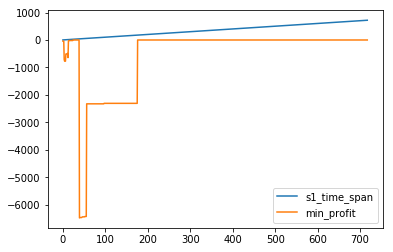

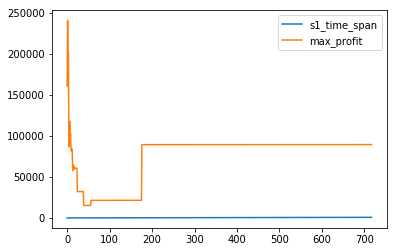

In [6]:
#%pylab
%matplotlib inline
result_df[["s1_time_span", "min_profit"]].plot()
result_df[["s1_time_span", "max_profit"]].plot()

In [7]:
result_df.to_csv("S1-12-720.xls", sep="\t", index=None)